In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import nltk
import re
import os
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import glob
from collections import Counter


/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
df=pd.read_csv("../input/news-summary/news_summary_more.csv")

In [3]:
df1=df.sample(50000)

In [4]:
text=df1.text

In [5]:
headlines=df1.headlines

In [6]:
def preprocess(text):
    text=text.lower()
    text=text.strip()
    #text=text.replace("'s","",text)
    text=re.sub(r'[^\w\d]'," ",text)
    text=re.sub(r'\d+','num',text)
    text=re.sub(r"¹","",text)
    text=re.sub(r"\s\w\s"," ",text)
    text=re.sub(r"\s{2,}"," ",text)
    text=text.strip()
    return text

In [7]:
processtext=text.apply(lambda x:preprocess(x))

In [8]:
processheadline=headlines.apply(lambda x:preprocess(x))

In [9]:
textwordcount=Counter()
for i in range(len(processtext)):
    textwordcount.update(processtext.iloc[i].split())

In [10]:
headlinewordcount=Counter()
for i in range(len(processheadline)):
    headlinewordcount.update(processheadline.iloc[i].split())

In [11]:
textokenizer=Tokenizer(num_words=30000,oov_token='<unk>')

In [12]:
len([i for i,j in textokenizer.word_counts.items() if j>=3])

0

In [13]:
textokenizer.fit_on_texts(processtext)
texttoken=textokenizer.texts_to_sequences(processtext)

In [14]:
textwordind=textokenizer.word_index
textwordind=dict([(i,j) for i,j in textwordind.items() if j<=30000])

In [15]:
textwordind['<pad>']=0

In [16]:
len(textwordind)

30001

In [17]:
headtokenizer=Tokenizer(num_words=16500,oov_token='<unk>')
headtokenizer.fit_on_texts(processheadline)

In [18]:
len([i for i,j in headtokenizer.word_counts.items() if j>=2])

16207

In [19]:
headwordind=headtokenizer.word_index
headwordind=dict([(i,j) for i,j in headwordind.items() if j<=16500])

In [20]:
headwordind['<pad>']=0
headwordind['<start>']=len(headwordind)
headwordind['<end>']=len(headwordind)

In [21]:
headwordind['<unk>']

1

In [22]:
headlinetoken=headtokenizer.texts_to_sequences(processheadline)

In [23]:
headlinetokenin=[[headwordind['<start>']]+i for i in headlinetoken]

In [24]:
headlinetokenout=[i+[headwordind['<end>']] for i in headlinetoken]

In [25]:
headlinetokenin[:4]

[[16501, 2, 1238, 6, 517, 493, 95, 94, 6, 2417, 9169],
 [16501, 6863, 641, 2, 535, 3, 1263, 2019, 382, 84, 800, 6, 2],
 [16501, 641, 54, 3, 69, 611, 2060, 4, 1049, 303, 206, 5455],
 [16501, 47, 125, 368, 1733, 2, 2, 81, 3, 502, 44, 1280, 1060, 7, 1803]]

In [26]:
texttokenpad=pad_sequences(texttoken,padding='post')
headlineinpad=pad_sequences(headlinetokenin,padding='post')
headlineoutpad=pad_sequences(headlinetokenout,padding='post')

In [27]:
maxtextlen=texttokenpad.shape[1]
maxsumlen=headlineinpad.shape[1]

In [28]:
texttokenpad.shape

(50000, 77)

In [29]:
maxtextlen

77

In [30]:
maxsumlen

17

In [31]:
h=3
numlayers=3

In [32]:
def multiheadattention(modelsize,h):
    querysize=modelsize//h  # querysize and valuesize are to be same 
    valuesize=modelsize//h
    keysize=modelsize//h
    wq=[tf.keras.layers.Dense(querysize,activation='relu') for _ in range(h)]
    wk=[tf.keras.layers.Dense(querysize,activation='relu') for _ in range(h)]
    wv=[tf.keras.layers.Dense(querysize,activation='relu') for _ in range(h)]
    wo=tf.keras.layers.Dense(modelsize)
    return wq,wk,wv,wo,keysize



In [33]:
def call(query,value,keysize,wq,wk,wv,wo,h):
    # query len and keylen can be different size like in decoder but in encoder they are of same length
    # they are same only in encoder but for decoder they will be different
    # keylen is same as value len in decoder
    heads=[]
    for i in range(h):
        score=tf.matmul(wq[i](query),wk[i](value),transpose_b=True)
        score/=tf.math.sqrt(tf.dtypes.cast(keysize,tf.float32)) # batch x querylen x keylen
        alignment=tf.nn.softmax(score,axis=2)
        head=tf.matmul(alignment,wv[i](value))
        heads.append(head)
    
    heads=tf.concat(heads,axis=2) # adds up valuesize dims which here is 64 across 2 dim to get 128
    # batch x valuelen x 128
    heads=wo(heads)
    return heads

In [34]:
h=3

In [35]:
def positional_embedding(pos, model_size):
    PE = np.zeros((1, model_size))
    for i in range(model_size):
        if i % 2 == 0:
            PE[:,i] = np.sin(pos / 10000 ** (i / model_size))
        else:
            PE[:,i] = np.cos(pos / 10000 ** ((i - 1) / model_size))
    return PE

# max_length = max(len(data_en[0]), len(data_fr_in[0]))
modelsize = 196

pes = []
for i in range(maxtextlen):
    pes.append(positional_embedding(i, modelsize))

pes = np.concatenate(pes, axis=0)
pes = tf.constant(pes, dtype=tf.float32)

In [36]:
x=tf.placeholder(tf.int32,shape=[None,maxtextlen])
yin=tf.placeholder(tf.int32,shape=[None,maxsumlen])
yout=tf.placeholder(tf.int32,shape=[None,maxsumlen])

In [37]:
pes

<tf.Tensor 'Const:0' shape=(77, 196) dtype=float32>

In [38]:
class encoder:
    def __init__(self,modelsize,maxtexlen,h):
        
        self.modelsize=modelsize
        self.maxtexlen=maxtexlen
        self.h=h
        self.embedvar=tf.keras.layers.Embedding(len(textwordind),modelsize)
        
        self.wq1,self.wk1,self.wv1,self.wo1,self.keysize1=multiheadattention(self.modelsize,self.h)
        self.d1=tf.keras.layers.Dense(4*modelsize,activation='relu')
        self.d11=tf.keras.layers.Dense(modelsize)
        self.batchnorm1=tf.keras.layers.BatchNormalization()
        self.batchnorm11=tf.keras.layers.BatchNormalization()
        
        self.wq2,self.wk2,self.wv2,self.wo2,self.keysize2=multiheadattention(self.modelsize,self.h)
        self.d2=tf.keras.layers.Dense(4*modelsize,activation='relu')
        self.d21=tf.keras.layers.Dense(modelsize)
        self.batchnorm2=tf.keras.layers.BatchNormalization()
        self.batchnorm21=tf.keras.layers.BatchNormalization()
        
        self.wq3,self.wk3,self.wv3,self.wo3,self.keysize3=multiheadattention(self.modelsize,self.h)
        self.d3=tf.keras.layers.Dense(4*modelsize,activation='relu')
        self.d31=tf.keras.layers.Dense(modelsize)
        self.batchnorm3=tf.keras.layers.BatchNormalization()
        self.batchnorm31=tf.keras.layers.BatchNormalization()
        
    def call(self,xinp):
        xembed=self.embedvar(xinp) # batch x textlen x modelsize
        
        sub1=[]
        for i in range(xembed.shape[1]):
            sub=xembed[:,i,:]+pes[i,:]
            sub1.append(tf.expand_dims(sub,axis=1))
        
        sub1=tf.concat(sub1,axis=1)
        
        sub11=call(sub1,sub1,self.keysize1,self.wq1,self.wk1,self.wv1,self.wo1,self.h)
        sub11=sub11+sub1
        subout=self.batchnorm1(sub11)
        subout=self.d1(subout)
        subout=self.d11(subout)
        sub2=sub11+subout
        sub2=self.batchnorm11(sub2)
        
        sub21=call(sub2,sub2,self.keysize2,self.wq2,self.wk2,self.wv2,self.wo2,self.h)
        sub21=sub21+sub2
        subout2=self.batchnorm2(sub21)
        subout2=self.d2(subout2)
        subout2=self.d21(subout2)
        sub3=sub21+subout2
        sub3=self.batchnorm21(sub3)
        
        sub31=call(sub3,sub3,self.keysize3,self.wq3,self.wk3,self.wv3,self.wo3,self.h)
        sub31=sub31+sub3
        subout3=self.batchnorm3(sub31)
        subout3=self.d3(subout3)
        subout3=self.d31(subout3)
        sub4=sub31+subout3
        sub4=self.batchnorm31(sub4)
        return sub4
        

In [39]:
encoder1=encoder(modelsize,maxtextlen,h)

In [40]:
encoderoutput=encoder1.call(x)

In [41]:
encoderoutput

<tf.Tensor 'batch_normalization_5/batchnorm/add_1:0' shape=(?, 77, 196) dtype=float32>

In [42]:
class decoder:
    def __init__(self,modelsize,h):
        self.modelsize=modelsize
        self.h=h
        self.maxsumlen=maxsumlen
        self.deembedvar=tf.keras.layers.Embedding(len(headwordind),modelsize)
        
        self.dwq1,self.dwk1,self.dwv1,self.dwo1,self.dkeysize1=multiheadattention(self.modelsize,self.h)
        self.dd1=tf.keras.layers.Dense(4*modelsize,activation='relu')
        self.dd11=tf.keras.layers.Dense(modelsize)
        self.dbatchnorm1=tf.keras.layers.BatchNormalization()
        self.dbatchnorm11=tf.keras.layers.BatchNormalization()
        
        self.dwq2,self.dwk2,self.dwv2,self.dwo2,self.dkeysize2=multiheadattention(self.modelsize,self.h)
        self.dd2=tf.keras.layers.Dense(4*modelsize,activation='relu')
        self.dd21=tf.keras.layers.Dense(modelsize)
        self.dbatchnorm2=tf.keras.layers.BatchNormalization()
        self.dbatchnorm21=tf.keras.layers.BatchNormalization()
        
        self.dwq3,self.dwk3,self.dwv3,self.dwo3,self.dkeysize3=multiheadattention(self.modelsize,self.h)
        self.dd3=tf.keras.layers.Dense(4*modelsize,activation='relu')
        self.dd31=tf.keras.layers.Dense(modelsize)
        self.dbatchnorm3=tf.keras.layers.BatchNormalization()
        self.dbatchnorm31=tf.keras.layers.BatchNormalization()
        
        self.den=tf.keras.layers.Dense(len(headwordind))
        
    def call(self,enout,yinput):
        
        deemb=self.deembedvar(yinput)
        
        sub=[]
        for i in range(deemb.shape[1]):
            s=call(tf.expand_dims(deemb[:,i,:],axis=1),deemb[:,:i,:],self.dkeysize1,self.dwq1,self.dwk1,self.dwv1,self.dwo1,self.h)
            sub.append(s)
        sub1=tf.concat(sub,axis=1)
        sub1=sub1+deemb
        sub1=self.dbatchnorm1(sub1)
        
        midsub=[]
        for i in range(sub1.shape[1]):
            s=call(tf.expand_dims(sub1[:,i,:],axis=1),enout,self.dkeysize2,self.dwq2,self.dwk2,self.dwv2,self.dwo2,self.h)
            midsub.append(s)
        sub2=tf.concat(midsub,axis=1)
        sub2=sub1+sub2
        sub2=self.dbatchnorm2(sub2)
        sub21=self.dd2(sub2)
        sub21=self.dd21(sub21)
        sub21=sub21+sub2
        sub3=self.dbatchnorm21(sub21)
        
        midsub1=[]
        for i in range(sub3.shape[1]):
            s=call(tf.expand_dims(sub3[:,i,:],axis=1),enout,self.dkeysize3,self.dwq3,self.dwk3,self.dwv3,self.dwo3,self.h)
            midsub1.append(s)
        sub4=tf.concat(midsub1,axis=1)
        sub4=sub4+sub3
        sub41=self.dbatchnorm3(sub4)
        sub41=self.dd3(sub41)
        sub41=self.dd31(sub41)
        sub41=sub41+sub4
        sub41=self.dbatchnorm31(sub41)
        logits=self.den(sub41)
        
        return logits

In [43]:
decoder2=decoder(modelsize,h)

In [44]:
len(headwordind)

16503

In [45]:
yin

<tf.Tensor 'Placeholder_1:0' shape=(?, 17) dtype=int32>

In [46]:
logits=decoder2.call(encoderoutput,yin)

In [47]:
logits.get_shape()

TensorShape([Dimension(None), Dimension(17), Dimension(16503)])

In [48]:
mask=tf.cast(tf.not_equal(yout,0),tf.float32)

In [49]:
loss1=tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=tf.one_hot(yout,len(headwordind)))

In [50]:
loss1=loss1*mask

In [51]:
loss=tf.reduce_mean(loss1)

In [52]:
trainoptimizer=tf.train.AdamOptimizer(learning_rate=0.001)
trainstep=trainoptimizer.minimize(loss)

In [53]:
sess=tf.InteractiveSession()

In [54]:
sess.run(tf.global_variables_initializer())

In [55]:
batchsize=64

In [56]:
count=0
trainloss=[]

In [57]:
for i in range(40):
    index=np.arange(30000)
    np.random.shuffle(index)
    for j in range(0,30000,100):
        ind=index[j:j+100]
        
        xinp=texttokenpad[ind]
        yinp1=headlineinpad[ind]
        yout1=headlineoutpad[ind]
    
        #print(xinp.shape)
        #print(yinp1.shape)
        #print(yout1.shape)
        _=sess.run(trainstep,feed_dict={x:xinp,yin:yinp1,yout:yout1})
        loss2=loss.eval({x:xinp,yin:yinp1,yout:yout1})
        count+=1
        trainloss.append(loss2)
        if count%20==0:
            print("Epoch:-",count," and loss is :-",loss2)

Epoch:- 20  and loss is :- 4.7327266
Epoch:- 40  and loss is :- 4.6317186
Epoch:- 60  and loss is :- 4.5747433
Epoch:- 80  and loss is :- 4.4879255
Epoch:- 100  and loss is :- 4.396972
Epoch:- 120  and loss is :- 4.5386953
Epoch:- 140  and loss is :- 4.406602
Epoch:- 160  and loss is :- 4.5059314
Epoch:- 180  and loss is :- 4.4038925
Epoch:- 200  and loss is :- 4.2837367
Epoch:- 220  and loss is :- 4.29807
Epoch:- 240  and loss is :- 4.1530757
Epoch:- 260  and loss is :- 4.2197747
Epoch:- 280  and loss is :- 4.168509
Epoch:- 300  and loss is :- 4.0657268
Epoch:- 320  and loss is :- 4.099449
Epoch:- 340  and loss is :- 4.0648804
Epoch:- 360  and loss is :- 4.0704503
Epoch:- 380  and loss is :- 3.998827
Epoch:- 400  and loss is :- 3.9947402
Epoch:- 420  and loss is :- 3.9858842
Epoch:- 440  and loss is :- 3.8425026
Epoch:- 460  and loss is :- 3.937625
Epoch:- 480  and loss is :- 3.9784696
Epoch:- 500  and loss is :- 3.868476
Epoch:- 520  and loss is :- 3.9594128
Epoch:- 540  and loss is 

In [58]:
import matplotlib.pyplot as plt

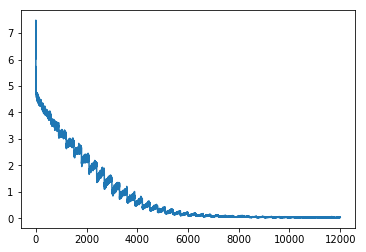

In [59]:
plt.plot(trainloss)

In [60]:
def predict(enout1,dinp1):
    
    deinput=tf.constant(np.array(dinp1).reshape((1,-1)),dtype=tf.int64)
    #print(deinput.shape)
    prediction1=decoder2.call(enout1,deinput)
    #print(prediction1.get_shape())
    prediction=tf.nn.softmax(prediction1,axis=-1)
    firstval=prediction.eval()
    #print(firstval.shape)
    word1=headindword[np.argmax(firstval[0,-1,:])]
    
    return word1

In [61]:
headindword=dict([(j,i) for i,j in headwordind.items()])

In [62]:
textindword=dict([(j,i) for i,j in textwordind.items()])

In [63]:
len(headindword)

16503

In [64]:

def printsent(index):
    enout=encoderoutput.eval({x:texttokenpad[index].reshape(1,texttokenpad.shape[1])})
    enout1=tf.constant(enout)
    count=0
    inp=[headwordind['<start>']]
    word='<start>'
    li=[]
    while count<15:
        #print(word)
        #print(inp)
        word=predict(enout1,inp)
        li.append(word)
        inp.append(headwordind[word])
        count+=1
    del(enout1)
    
    print("predicted sentence:"," ".join(li))
    print("----")
    print("full text:-"," ".join([textindword[i] for i in texttokenpad[index]]))
    print("----")
    print("original summary:-"," ".join([headindword[i] for i in headlineoutpad[index]]))

In [65]:
printsent(3) # After training for 18000 steps and 60 epochs

predicted sentence: no one would spend num num cr to change his image dutt on sanju <end>
----
full text:- dismissing allegations against director rajkumar hirani of whitewashing his image through sanju sanjay dutt on thursday said don think anyone would spend num num crore to change his image he added ve told the truth and it has been accepted by india the movie collection shows that after the film ended broke down couldn believe it he further said <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
----
original summary:- no one would spend num num cr to change his image dutt on sanju <end> <pad> <pad>


In [66]:
printsent(5)

predicted sentence: force india claim numth and numth place in spanish grand prix <end> <end> <end> <end>
----
full text:- force india formula one team drivers sergio perez and <unk> <unk> finished in the fourth and fifth spot respectively in the spanish grand prix in barcelona on sunday mercedes lewis hamilton won the race by beating ferrari sebastian vettel and red bull daniel ricciardo who finished second and third respectively <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
----
original summary:- force india claim numth and numth place in spanish grand prix <end> <pad> <pad> <pad> <pad> <pad>


In [67]:
printsent(6)

predicted sentence: indian startup rooter among num chosen for sports accelerator program <end> <end> <end> <end> <end>
----
full text:- sports social engagement platform rooter is the only indian startup among the num startups chosen for num lead sports accelerator program founded by piyush kumar and akshat goel in num rooter is sports social gaming platform that connects sports fans and engages them during live matches it also offers them match prediction games sports social feed across eight sports <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
----
original summary:- indian startup rooter among num chosen for sports accelerator program <end> <pad> <pad> <pad> <pad> <pad> <pad>
